# Diafiltration Cost Uncertainty Quantification and Propagation

Uncertainties in market conditions—such as lithium price fluctuations over the past decade (illustrated below)—can significantly influence technology selection and investment decisions. In critical mineral recovery plant, stakeholders and investors are ofteninterested in understanding:
- Which tecchnical or economic parameters most strongly affect the cost of recovery?
- How sensitive is system performance to market volatility?
- How do uncertain inputs propagate through the process model and impact key decision indicators?

These questions are particularly important for emerging technologies where both market and process uncertainties remain substantial.

In this tutorial, we study a diafiltration process for lithium and cobal recovery under costing and unit model parameter uncertainty. We explore how uncertainty in key parameters propagates to a key performance indicator: cost of recovery.

![Lithium_historical_price_from_dailymetalprices.png](./Lithium_historical_price_from_dailymetalprices.png)

A range of uncertainty modeling approaches and sampling strategies are demonstrated, including the development of probability distributions from historical data.

__In this tutorial, you will learn how to:__
- Define alternative technology scenarios (e.g., different membrane sieving coefficients)
- Identify and specify uncertainmodel parameters
- Construct probability distributions
- Select appropriate sampling strategies
- Run optimization for selected samples
- Analyze and visualize results to support decision making

By the end of this tutorial, you will have a structured workflow for performing uncertianty quantification in a process modeling and costing framework.

## Step 1: Imports and Setup

Import necessary packages.

In [1]:
import prommis.costing.uq.diafiltration_cost_uq as uq
import logging

## Step 2: UQ Model Specification

### Step 2.1: Build model and specify variables and bounds
After importing the required packages, the next step is to construct the diafiltration model and define the decesion variables along with their bounds. Use `build_diafiltration_model` function to build the model. Within the `build_diafiltration_model`, it build the flowsheet, initialize the model, apply costing to the model, and solve for deterministic model minimum cost of recovery. Details please see [here](https://github.com/prommis/prommis/blob/main/src/prommis/costing/uq/diafiltration_cost_uq.py). 

Later, call the `decision_variables_bounds` function to activate the decision variables and their bounds. 

In this case study, the membrane stage lengths are identified as decision variables. Their bounds are specified based on literature values reported in: Wamble, N.P., Eugene, E.A., Phillip, W.A., Dowling, A.W., 'Optimal Diafiltration Membrane Cascades Enable Green Recycling of Spent Lithium-Ion Batteries', ACS Sustainable Chem. Eng. 2022, 10, 12207−12225.

| Variables	| lower bound	| upper bound| units |
|-----------|---------------|------------|------------|
| stage1 length	| 0.1	| 10000 | m |
| stage2 length	| 0.1	| 10000 | m |
| stage3 length	| 0.1	| 10000 | m |

In [2]:
# Silence warnings for better results view
logging.getLogger("pyomo").setLevel(logging.ERROR)

# Build the model with default contributes
build_diafiltration_model = uq.build_diafiltration_model(
    sieving_coeffs=(1.3, 0.5), technology_name=None
)

# Now the variables of the diafiltraiton process related variables is availabe,
# and can be accessed to set boundaries
decision_variables_bounds = uq.decision_variables_bounds(build_diafiltration_model)

2026-02-18 10:09:19 [INFO] idaes.init.fs.stage1: Stream Initialization Completed.
2026-02-18 10:09:20 [INFO] idaes.init.fs.stage1: Initialization Completed, optimal - <undefined>
2026-02-18 10:09:20 [INFO] idaes.init.fs.mix1: Initialization Complete: optimal - <undefined>
2026-02-18 10:09:20 [INFO] idaes.init.fs.stage2: Stream Initialization Completed.
2026-02-18 10:09:20 [INFO] idaes.init.fs.stage2: Initialization Completed, optimal - <undefined>
2026-02-18 10:09:20 [INFO] idaes.init.fs.mix2: Initialization Complete: optimal - <undefined>
2026-02-18 10:09:20 [INFO] idaes.init.fs.stage3: Stream Initialization Completed.
2026-02-18 10:09:20 [INFO] idaes.init.fs.stage3: Initialization Completed, optimal - <undefined>
2026-02-18 10:09:20 [INFO] idaes.init.fs.stage3: Stream Initialization Completed.
2026-02-18 10:09:20 [INFO] idaes.init.fs.stage3: Initialization Completed, optimal - <undefined>


### Step 2.2: Identify uncertain parameters

There are uncertainties associated with both market prices and process-related parameters. For demonstration purpose, the uncertainty ideantified here are not exhaustive; rather, we focus on the most influential parameters.

All cost used in this study are converted to 2021 dollars.

__Market-Related Uncertainties__
- Membrane cost ($\$/\text{m}^2$). Membrane unit price changes as technology advances and manufacturing scales evolve. A cost range of [36, 450] ($\$/\text{m}^2$) is referenced from the [literature](https://doi.org/10.1016/j.desal.2012.07.010). 
- Electricity cost ($\$/\text{kWh}$). Electricity prices fluctuate daily, sensonaly, and by location. In this case study, daily electricity price from Pennsylvania (PA) over the past ten years are used. Data are obtained from [U.S. Energy Information Administration](https://www.eia.gov/electricity/data/state/). 
- Lithium price ($\$/\text{kg}$). Lithium prices vary significantly due to global supply-demand dynamics. Historical data from the past eight years are used in this study, referenced from [Daily Metal Prices](https://www.dailymetalprice.com/metalpricecharts.php?c=li&u=kg&d=240).
- Cobalt price ($\$/\text{kg}$). Similar to lithium, cobalt prices fluctuate frequently. Historical data from the past ten years are used, sourced from [trading economics](https://tradingeconomics.com/commodity/cobalt).
- Coporate Income tax rate (%). Income tax affects operating ocsts and includes both federal and state components. Tax rate do not change frequently, although state-level adjustments may occur periodically (typically annually at most). To maintain consistency, PA state tax rate are used in this study. Reference: [Tax Foundation](https://taxfoundation.org/data/all/state/state-corporate-income-tax-rates-brackets/).
- Royalty charge percentage of revenue (%). Royalty rate vary across plants and technologies. Literature reports typical ranges between 1% to 7%. References include: [1](https://law.shu.edu/documents/industry-notes-mb1018.pdf), [2](https://www.upcounsel.com/patent-licensing-royalty-rates), [3](https://ideanav.co.za/commercialisation/royalty-rates/), [4](https://selfserve.royaltysource.com/royaltyrateindustrystudy/pdf/RoyaltyRate-Industry-Summary-Reports-Overview.pdf)

__Process and Operational Uncertianties__:
- Membrane replacement factor ($\#/\text{year}$). Due to fouling, membranes typically require replacement every 5-10 years.
- Pump efficiency (dimensionless). Pumps are major equipment in the diafiltration process. Their efficiency directly impacts energy consumption and operating cost. literature reports that pump efficiency can range from 0.1 to 1. [reference](https://doi.org/10.1533/9780857092755.1.42).
- Operating days per year (days/year). Process plants may shut down periodically for maintenance or operational adjustments, resulting in fewer than 365 operating days annually. In this study, the operating days are assumed to range from 300 to 365 days per year.
- Lang factor (dimensionless). The Lang factor accounts for indirect capital costs such as installation, piping, construction labor, plant services, and site improvements, etc. Details are provided in the [PrOMMiS costing](https://github.com/prommis/prommis/blob/main/src/prommis/uky/costing/ree_plant_capcost.py). Depending on process specificaiton, the Lang factor typically ranges from 2 to 5.93. Reference: Seider, W. D., Lewin, D. R., Seader, J. D., Widagdo, S., Gani, R., Ng, K. M. (2017). Product and Process Design Principles: Synthesis, Analysis and Evaluation. United Kingdom: Wiley.  

In [3]:
# Identify uncertain parameters
uncertain_parameters = uq.identify_uncertain_params(build_diafiltration_model)

### Step 2.3: Assign uncertainty distribtutions

After identifying and defining the uncertain parameters, the next step is to assign appropriate probability distribution to represent their uncertainty.

According to the [NASA cost estimating handbook](https://www.nasa.gov/wp-content/uploads/2020/11/ceh_appg.pdf?emrc=67ab000a79e2d), triangular distributions are commonly applied to work breakdown structure element when limited data are available but reasonable estimates of minimum, most likely, and maximum values exist. In this study, __pump efficiency__, __membrane cost__, and __operating days per year__ are modeled using triangular distributions. These parameters typically have a preferred (mode) value, along with referenced or assumed lower and upper bounds.

Lognormal distributions are widely used in cost and price analysis. Compared to the normal distribution, the lognormal distribution is strictly nonnegative and right-skewed. Commodity prices such as __electricity__, __lithium__, and __cobalt__ are unlikely to take negative values and often exhibit upward skewness due to supply constraints and market volatility. In contrast, the normal distribution is symmetric and allows negative values, which are not appropriate for modeling prices. Therefore, the lognormal distribution is preferred for representing resource and material price uncertainty.

A helper function is provided to construct lognormal distributions directly from historical data. Users may replace the provided .csv files with their own datasets. When doing so, ensure that the file path correctly points to the stored data location.

For parameters with limited references but known lower and upper bounds, a uniform distribution is applied. This approach is used for the __membrane replacement factor__, __Lang factor__, __royalty charge percentage of revenue__, and __income tax rate__ when sufficient historical data are not available.

Users may also define and use alternative uncertainty distribution methods if more appropriate for their specific application.

In [4]:
# Directory for historical data
script_dir = uq.get_script_dir()

# Lognormal params from historical data
# Lithium price USD/kg
li_file = uq.os.path.join(script_dir, "lithium_price_USA_dailymetalprice_yr2021.csv")
li_df = uq.pd.read_csv(li_file)
li_data = li_df["2021_$/kg"].values
mu_li, sigma_li = uq.estimate_lognormal_params_from_data(li_data)

# Cobalt price USD/kg
co_file = uq.os.path.join(script_dir, "cobalt_price_USA_tradingeconomics_yr2021.csv")
co_df = uq.pd.read_csv(co_file)
co_data = co_df["2021_$/kg"].values
mu_co, sigma_co = uq.estimate_lognormal_params_from_data(co_data)

# Electricity price of Pennsylvania
elec_file = uq.os.path.join(
    script_dir, "iea_1990_2025_industry_elec_monthly_price_PA.csv"
)
elec_df = uq.pd.read_csv(elec_file)
elec_data = elec_df["PA_2021_$/kWh"].values
mu_elec, sigma_elec = uq.estimate_lognormal_params_from_data(elec_data)

# Determin what distribution is in lognormal distribution
cp = build_diafiltration_model.fs.costing
lognormal_params = {
    cp.electricity_cost.getname(): {"mu": mu_elec, "sigma": sigma_elec},
    cp.Li_price.getname(): {"mu": mu_li, "sigma": sigma_li},
    cp.Co_price.getname(): {"mu": mu_co, "sigma": sigma_co},
}

# Income tax empirical samples
income_tax_file = uq.os.path.join(script_dir, "PA_income_tax.csv")
income_tax_samples = uq.load_income_tax_samples_from_csv(
    income_tax_file, column_name="2021_tax"
)

# Assign uncertainty specs for uncertain parameters
uncertainty_specs = uq.build_uncertainty_specs(
    build_diafiltration_model,
    lognormal_params=lognormal_params,
    income_tax_samples=income_tax_samples,
)

## Step 3: Sampling methods

Once the uncertain parameters have been defined and their probability distributions assigned, the next step is to generate samples that represent these distributions.

In general, a larger sample size provides a better representation of the underlying distributions. However, increasing the sample size also increases computational cost. To balance statistical reliability and computational efficiency, a sample size of __200__ is used in this case study. On a typical workstation, this requires approximately __two__ minutes to complete. Users who wish to explore larger sample sizes are encouraged to run the analysis locally, where longer computational times can be accommodated.

Two sampling methods are available in this model, and all uncertain paramters are sampled indipendently:

- Latin Hypercube Sampling (LHS)

- Monte Carlo sampling

Both methods independently sample the 10 uncertain parameters, meaning that no correlations are assumed among them. If correlations between parameters are relevant for a specific study, additional modeling considerations would be required.

In [5]:
# Set sampl size
n_samples = 200

# Chose between LHS and Monte carlo sampling method.
# Chanse use_lhs=False to activate Monte Carlo sampling method.
use_lhs = False

# Set up solver
max_iter = 5000
tol = 1e-6
acceptable_tol = 1e-5
local_solver = uq.pyo.SolverFactory("ipopt")
local_solver.options["max_iter"] = max_iter
local_solver.options["tol"] = tol
local_solver.options["acceptable_tol"] = acceptable_tol
random_seed = 1


def chose_sampling(
    m,
    uncertain_params,
    uncertainty_specs,
    n_samples,
    solver=local_solver,
    random_seed=1,
):
    if use_lhs:
        # LHS sampling and solve the model.
        samples = uq.run_LHS(
            m,
            uncertain_params,
            uncertainty_specs,
            n_samples=n_samples,
            solver=local_solver,  # Default IPOPT
            random_seed=random_seed,
        )
    else:
        # Monte carlo sampling and solve the model
        samples = uq.run_monte_carlo(
            m,
            uncertain_params,
            uncertainty_specs,
            n_samples=n_samples,
            solver=local_solver,  # Default IPOPT
            random_seed=random_seed,
        )

    return samples

After executing the previous cell, the uncertainty propagation results are available and ready for analysis in the next steps.

## Step 4: Analyze and interprete results

As described earlier, the objective of uncertainty quantification is to understand how the __cost of recovery__ changes under variations in market conditions and process-related parameters. In particular, we aim to identify which uncertain parameters have the greatest impact on the key performance indicator of interest—in this case, the cost of recovery.

A variety of analytical approaches can be applied to interpret the results. In this case study, the following analyses are demonstrated:

- Sensitivity ranking

- Statistical summary

- Histogram visualization

- Confidence interval estimation

Before performing any analysis, the simulation results must be cleaned. As observed in the output from the previous cell, some samples may terminate with warnings, infeasibility, or due to reaching the maximum number of solver iterations. Consequently, not all sampled cases yield valid optimized results.

Therefore, the first step in the analysis is to filter the dataset and retain only the cases with successful solver termination.

In [6]:
# Keep only successful solves
samples = chose_sampling(
    build_diafiltration_model,
    uncertain_parameters,
    uncertainty_specs,
    n_samples,
    solver=local_solver,
    random_seed=1,
)
valid = ~uq.np.isnan(samples[1])  # Optimization objective: Cost of recovery
param_samples = samples[2][valid, :]  # Valid parameter samples
recovery_cost_samples = samples[1][valid]  # Valid cost of recovery

### Step 4.1: Sensitivity analysis
Two sensitivity analysis methods are applied to evaluate how uncertain parameters influence the optimization objective—minimizing the cost of recovery:

- Standardized Linear Regression Coefficients (SLRC)

- Pearson Correlation Coefficients

These methods quantify the relative impact of each uncertain parameter on the objective function.

Using two different sensitivity approaches allows for cross-validation of the results and helps ensure that the conclusions are not strongly biased by the choice of method. Consistency between the two analyses increases confidence in identifying the most influential parameters.

In [7]:
# Get parameter names for analysis
param_names = [p.getname() for p in uncertain_parameters]

# Sensitivity analysis
analyze_sensitivity = uq.analyze_sensitivity(
    param_samples,
    recovery_cost_samples,
    param_names,
    technology_name=None,  # Default technology Case A is used.
)



#############################
Sensitivity analysis: technology
#############################

=== Sensitivity ranking (standardized linear coefficients) ===
Co_price                                  |beta| = 7.11
income_tax_percentage                     |beta| = 5.89
Li_price                                  |beta| = 0.942
royalty_charge_percentage_of_revenue      |beta| = 0.781
operating_days_per_year                   |beta| = 0.492
membrane_cost                             |beta| = 0.296
Lang_factor                               |beta| = 0.189
factor_membrane_replacement               |beta| = 0.137
electricity_cost                          |beta| = 0.134
pump_efficiency                           |beta| = 0.0187

=== Sensitivity ranking (|Pearson correlation|) ===
Co_price                                  |rho|  = 0.75
income_tax_percentage                     |rho|  = 0.628
Li_price                                  |rho|  = 0.208
Lang_factor                               |rho|  

As shown in the results table above, both sensitivity analysis methods indicate that the three most influential uncertain parameters are cobalt price, income tax rate, and lithium price.

In contrast, parameters primarily associated with fixed costs—such as membrane cost, pump efficiency, and membrane replacement factor—exhibit relatively low sensitivity with respect to the cost of recovery.

This suggests that market-driven price variables have a stronger impact on economic performance than certain process-related cost parameters under the assumptions of this case study.

### Step 4.2: Uncertainty propogation and quantiles
The uncertainties in the input parameters are propagated through the model to evaluate their impact on the output—specifically, the __cost of recovery__.

This analysis helps quantify the overall economic uncertainty associated with the process and supports risk-informed decision making.

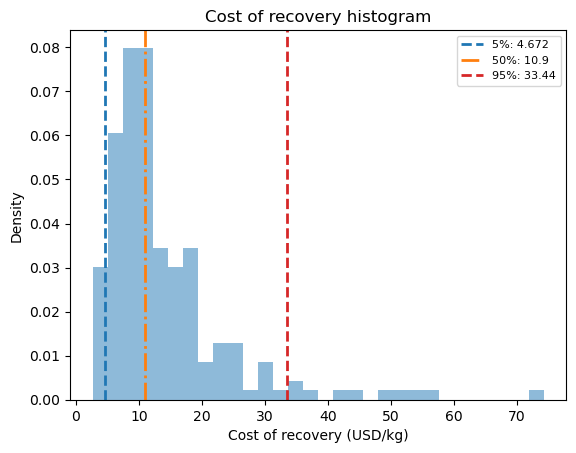

In [8]:
# Single technology histogram and confidence interval
uq.plt.hist(recovery_cost_samples, bins=30, density=True, alpha=0.5)
uq.plt.title("Cost of recovery histogram")
uq.plt.xlabel("Cost of recovery (USD/kg)")
uq.plt.ylabel("Density")

# Mark key quantiles
rec = uq.np.asarray(samples[1], dtype=float)  # Cost of recovery
valid_cost_of_recovery = rec[~uq.np.isnan(rec)]
if valid_cost_of_recovery.size > 0:
    q5, q50, q95 = uq.np.percentile(valid_cost_of_recovery, [5, 50, 95])
    uq.plt.axvline(q5, linestyle="--", linewidth=2, color="tab:blue")
    uq.plt.axvline(q50, linestyle="-.", linewidth=2, color="tab:orange")
    uq.plt.axvline(q95, linestyle="--", linewidth=2, color="tab:red")
    uq.plt.legend(
        [f"5%: {q5:.4g}", f"50%: {q50:.4g}", f"95%: {q95:.4g}"],
        fontsize=8,
    )

As shown in the figure above, the mode of the cost of recovery is approximately 10.9 $\$/\text{kg}$. However, the cost increases to approximately 33.44 $\$/\text{kg}$ at the 95th percentile, meaning that 95% of the uncertainty samples result in a cost of recovery at or below this value while still satisfying the recovery criteria.

It is also informative to examine how the decision variables adjust under uncertainty, as this provides additional insight into how the optimization responds to varying market and process conditions.

Text(0, 0.5, 'Density')

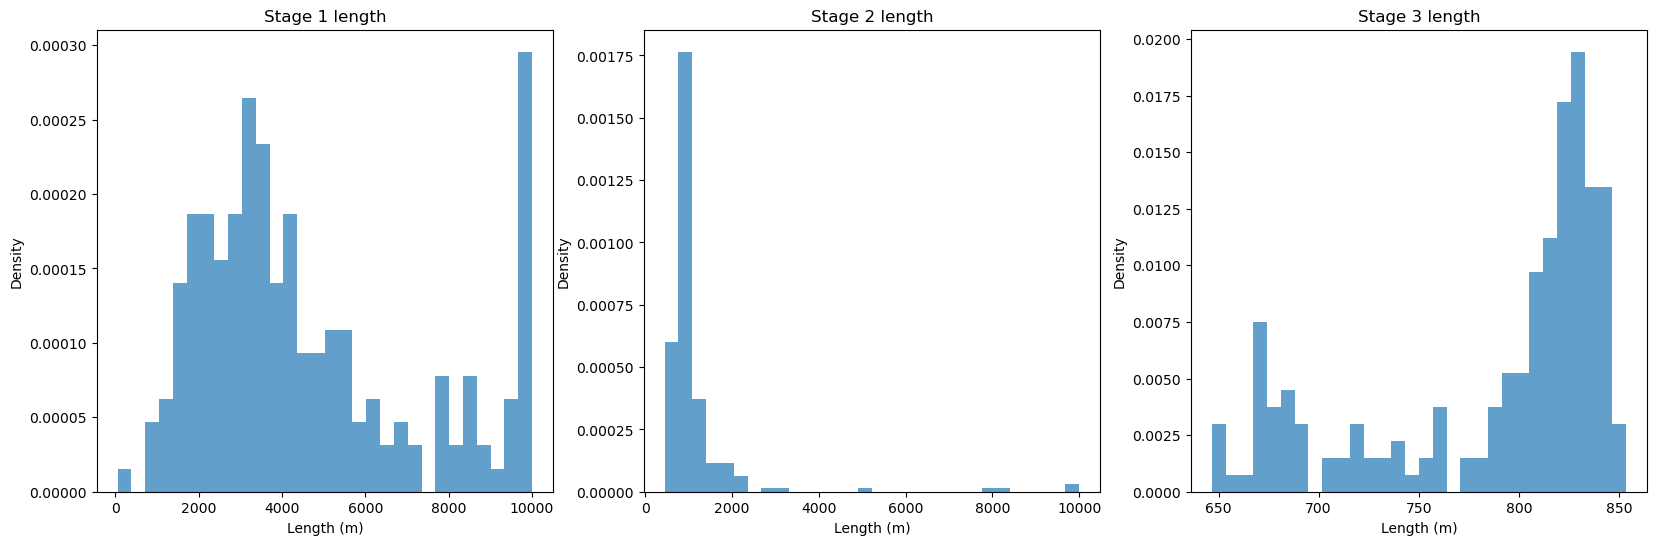

In [9]:
# Plot membrane length histogram
fig, axes = uq.plt.subplots(1, 3, figsize=(20, 6))
L1 = uq.np.asarray(samples[3], dtype=float)[valid]  # stage1_len
L2 = uq.np.asarray(samples[4], dtype=float)[valid]  # stage2_len
L3 = uq.np.asarray(samples[5], dtype=float)[valid]  # stage3_len

axes[0].hist(L1[~uq.np.isnan(L1)], bins=30, density=True, alpha=0.7)
axes[0].set_title(f"Stage 1 length")
axes[0].set_xlabel("Length (m)")
axes[0].set_ylabel("Density")

axes[1].hist(L2[~uq.np.isnan(L2)], bins=30, density=True, alpha=0.7)
axes[1].set_title(f"Stage 2 length")
axes[1].set_xlabel("Length (m)")
axes[1].set_ylabel("Density")

axes[2].hist(L3[~uq.np.isnan(L3)], bins=30, density=True, alpha=0.7)
axes[2].set_title(f"Stage 3 length")
axes[2].set_xlabel("Length (m)")
axes[2].set_ylabel("Density")

The figure above indicates that, under uncertainty, the minimized cost of recovery is most strongly influenced by the membrane length in __Stage 1__, followed by __Stage 2__, while __Stage 3__ has the least impact.

The optimized membrane length for Stage 3 typically falls within the range of approximately __650–850 m__. Considering the uncertainty in both market and process parameters, selecting membrane lengths of approximately __3800 m__, __1000 m__, and __830 m__ for Stages 1, 2, and 3, respectively, is most likely to achieve a low cost of recovery.

Descriptive statistics can be generated to further characterize system behavior under uncertainty.

In [10]:
print(f"\n=== Summary statistics ===")
print(f"Valid samples: {valid_cost_of_recovery.size}/{n_samples}")
if valid_cost_of_recovery.size > 0:
    mean_cost = uq.np.mean(valid_cost_of_recovery)
    std_cost = uq.np.std(valid_cost_of_recovery, ddof=1)
    q5, q50, q95 = uq.np.percentile(valid_cost_of_recovery, [5, 50, 95])
    print(f"Mean cost_of_recovery: {mean_cost:.6f}")
    print(f"Std  cost_of_recovery: {std_cost:.6f}")
    print(f"5% / 50% / 95% quantiles: {q5:.6f}, {q50:.6f}, {q95:.6f}")


=== Summary statistics ===
Valid samples: 194/200
Mean cost_of_recovery: 14.030858
Std  cost_of_recovery: 10.331237
5% / 50% / 95% quantiles: 4.671828, 10.897620, 33.438110


The results indicate that the mean cost of recovery under uncertainty is 14.03 $\$/kg$, with standard deviation of 10.33. Furthermore, there is a 95% probability that the cost of recovery will be bellow 33.438 $\$/kg$.

### Step 4.3: Compare technologies

The framework also allows for the comparison of different technologies under the same uncertainty assumptions. In the example below, alternative technologies are represented by different membrane sieving coefficients.

This approach can be extended to compare entirely different process configurations that produce lithium and cobalt. However, it is important to note that alternative processes may introduce additional unit-model-specific uncertainties and parameters that must be carefully defined and incorporated into the uncertainty analysis.

Please note that the following section compares two different technologies, each evaluated with 200 samples. This section will take approximately __four__ minutes to complete.

In [11]:
technologies = {
    "Li_sc=1.3, Co_sc=0.5": (1.3, 0.5),
    "Li_sc=1.5, Co_sc=0.8": (1.5, 0.8),
}
results_by_technology = {}

for technology_name, sieving_coeffs in technologies.items():
    print(f"\n=== Running technology {technology_name} ===")

    m = uq.build_diafiltration_model(
        sieving_coeffs=sieving_coeffs, technology_name=technology_name
    )
    uq.decision_variables_bounds(m)

    det_results = local_solver.solve(m)
    uq.pyo.assert_optimal_termination(det_results)
    det_obj = uq.pyo.value(m.fs.costing.cost_of_recovery)
    print(f"Deterministic optimal cost_of_recovery: {det_obj:.6f}")

    uncertain_params = uq.identify_uncertain_params(m)
    param_names = [p.getname() for p in uncertain_params]

    # rebuild specs for this model
    cp = m.fs.costing
    lognormal_params_this = {
        cp.electricity_cost.getname(): {"mu": mu_elec, "sigma": sigma_elec},
        cp.Li_price.getname(): {"mu": mu_li, "sigma": sigma_li},
        cp.Co_price.getname(): {"mu": mu_co, "sigma": sigma_co},
    }

    uncertainty_specs_this = uq.build_uncertainty_specs(
        m, lognormal_params=lognormal_params_this, income_tax_samples=income_tax_samples
    )

    samples = chose_sampling(
        m,
        uncertain_params,
        uncertainty_specs_this,
        n_samples,
        solver=local_solver,
        random_seed=1,
    )
    (
        samples_first_param,
        recovery_cost_samples,
        param_samples,
        stage1_len,
        stage2_len,
        stage3_len,
    ) = samples
    valid = ~uq.np.isnan(recovery_cost_samples)

    param_names = [p.getname() for p in uncertain_params]

    results_by_technology[technology_name] = dict(
        samples_first_param=samples_first_param,
        recovery_cost_samples=recovery_cost_samples,
        param_samples=param_samples,
        stage1_len=stage1_len,
        stage2_len=stage2_len,
        stage3_len=stage3_len,
        valid=valid,
        det_obj=det_obj,
        param_names=param_names,
        m=m,
    )

    valid_cost = recovery_cost_samples[valid]
    print(f"\n=== Summary statistics: {technology_name} ===")
    print(f"Valid samples: {valid_cost.size}/{n_samples}")
    if valid_cost.size:
        print("Mean:", uq.np.mean(valid_cost), "Std:", uq.np.std(valid_cost, ddof=1))


=== Running technology Li_sc=1.3, Co_sc=0.5 ===
2026-02-18 10:10:21 [INFO] idaes.init.fs.stage1: Stream Initialization Completed.
2026-02-18 10:10:21 [INFO] idaes.init.fs.stage1: Initialization Completed, optimal - <undefined>
2026-02-18 10:10:21 [INFO] idaes.init.fs.mix1: Initialization Complete: optimal - <undefined>
2026-02-18 10:10:21 [INFO] idaes.init.fs.stage2: Stream Initialization Completed.
2026-02-18 10:10:22 [INFO] idaes.init.fs.stage2: Initialization Completed, optimal - <undefined>
2026-02-18 10:10:22 [INFO] idaes.init.fs.mix2: Initialization Complete: optimal - <undefined>
2026-02-18 10:10:22 [INFO] idaes.init.fs.stage3: Stream Initialization Completed.
2026-02-18 10:10:22 [INFO] idaes.init.fs.stage3: Initialization Completed, optimal - <undefined>
2026-02-18 10:10:22 [INFO] idaes.init.fs.stage3: Stream Initialization Completed.
2026-02-18 10:10:22 [INFO] idaes.init.fs.stage3: Initialization Completed, optimal - <undefined>
Deterministic optimal cost_of_recovery: 0.03295

From the results above, it can be observed that increasing the sieving coefficient leads to a slight increase in the mean cost of recovery. Examining the optimized membrane lengths shown below suggests that this increase is likely driven by a longer membrane length in Stage 1.

A higher membrane length is required to achieve the desired separation performance for lithium and cobalt, which in turn contributes to the increase in recovery cost.

In [12]:
# Sensitivity analysis
for tech, d in results_by_technology.items():
    print(f"\n=== Sensitivity: {tech} ===")
    uq.analyze_sensitivity(
        d["param_samples"],
        d["recovery_cost_samples"],
        d["param_names"],
        technology_name=tech,
    )


=== Sensitivity: Li_sc=1.3, Co_sc=0.5 ===


#############################
Sensitivity analysis: Li_sc=1.3, Co_sc=0.5
#############################

=== Sensitivity ranking (standardized linear coefficients) ===
Co_price                                  |beta| = 6.99
income_tax_percentage                     |beta| = 5.84
Li_price                                  |beta| = 0.964
royalty_charge_percentage_of_revenue      |beta| = 0.73
operating_days_per_year                   |beta| = 0.42
membrane_cost                             |beta| = 0.213
factor_membrane_replacement               |beta| = 0.203
Lang_factor                               |beta| = 0.186
electricity_cost                          |beta| = 0.0693
pump_efficiency                           |beta| = 0.00621

=== Sensitivity ranking (|Pearson correlation|) ===
Co_price                                  |rho|  = 0.749
income_tax_percentage                     |rho|  = 0.63
Li_price                                  |rho|  = 0.

Both technologies exhibit the same sensitivity ranking, suggesting that their underlying cost structures and parameter influences are closely aligned. Which means that under these two technologies, the priority way to reduce cost is the same.

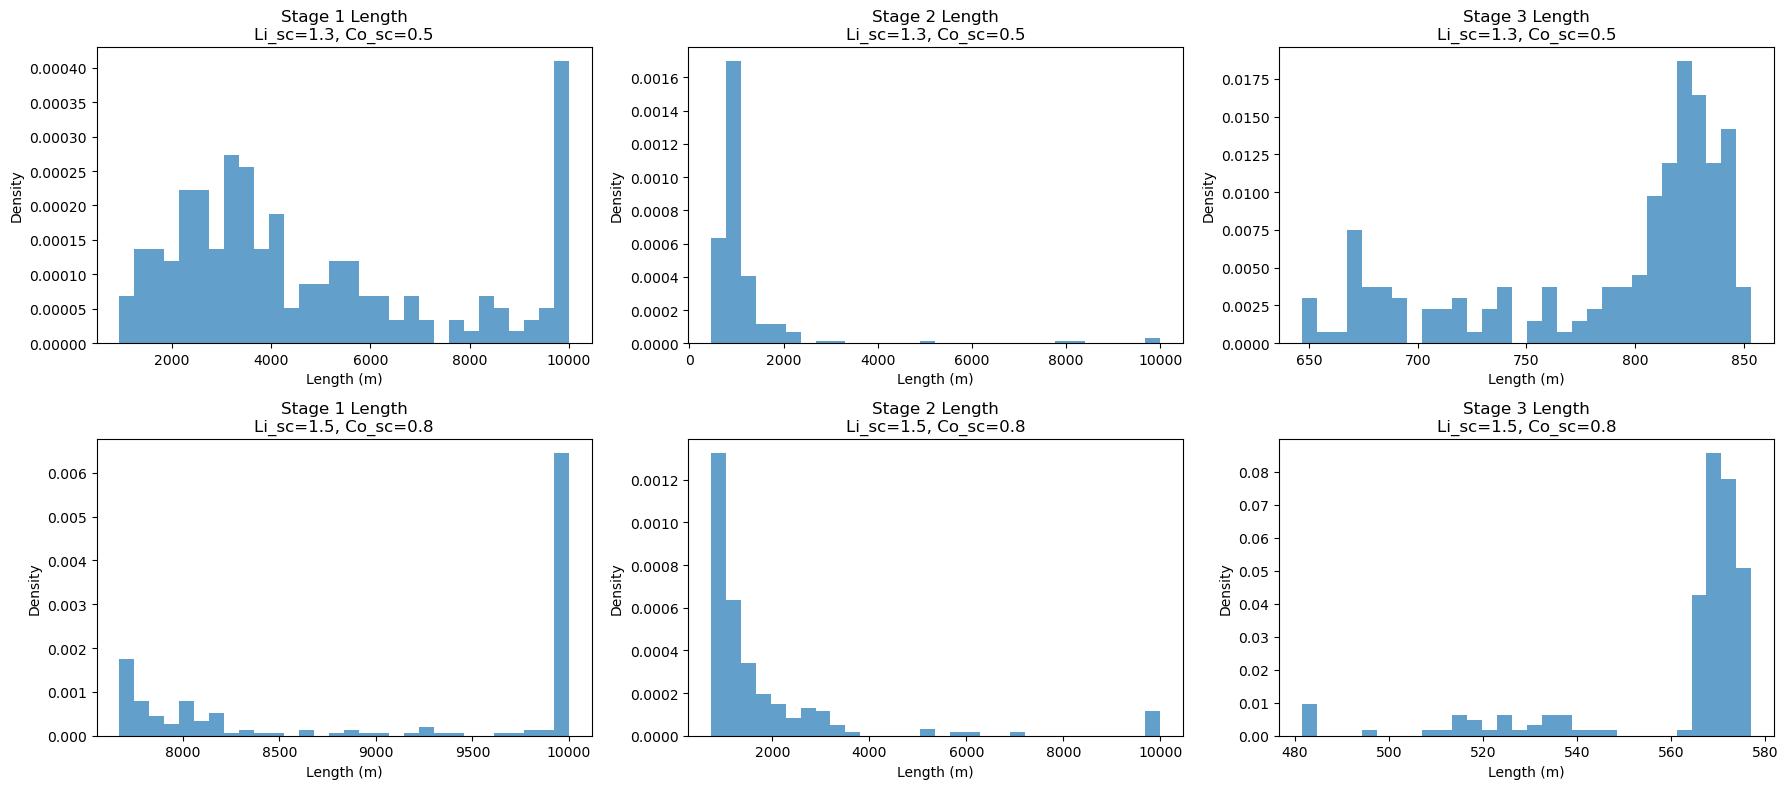

In [13]:
# ---------- PLOT ----------
techs = list(results_by_technology.keys())
ntech = len(techs)

# (A) 2 rows x 3 cols: stage length histograms
fig, axes = uq.plt.subplots(ntech, 3, figsize=(18, 4 * ntech), squeeze=False)

for r, tech in enumerate(techs):
    d = results_by_technology[tech]
    valid = d["valid"]

    L1 = uq.np.asarray(d["stage1_len"], dtype=float)[valid]
    L2 = uq.np.asarray(d["stage2_len"], dtype=float)[valid]
    L3 = uq.np.asarray(d["stage3_len"], dtype=float)[valid]

    axes[r, 0].hist(L1, bins=30, density=True, alpha=0.7)
    axes[r, 0].set_title(f"Stage 1 Length\n{tech}")
    axes[r, 0].set_xlabel("Length (m)")
    axes[r, 0].set_ylabel("Density")

    axes[r, 1].hist(L2, bins=30, density=True, alpha=0.7)
    axes[r, 1].set_title(f"Stage 2 Length\n{tech}")
    axes[r, 1].set_xlabel("Length (m)")
    axes[r, 1].set_ylabel("Density")

    axes[r, 2].hist(L3, bins=30, density=True, alpha=0.7)
    axes[r, 2].set_title(f"Stage 3 Length\n{tech}")
    axes[r, 2].set_xlabel("Length (m)")
    axes[r, 2].set_ylabel("Density")

uq.plt.tight_layout()
uq.plt.show()

The optimized membrane lengths shift slightly between the two technologies. As the sieving coefficients increase, the membrane length ranges for Stages 1 and 3 become narrower, and the corresponding density values increase. This suggests that, for a given fixed membrane length, the technology with sieving coefficients of (1.5, 0.8) has a higher probability of achieving lithium and cobalt recovery within a specified cost range.

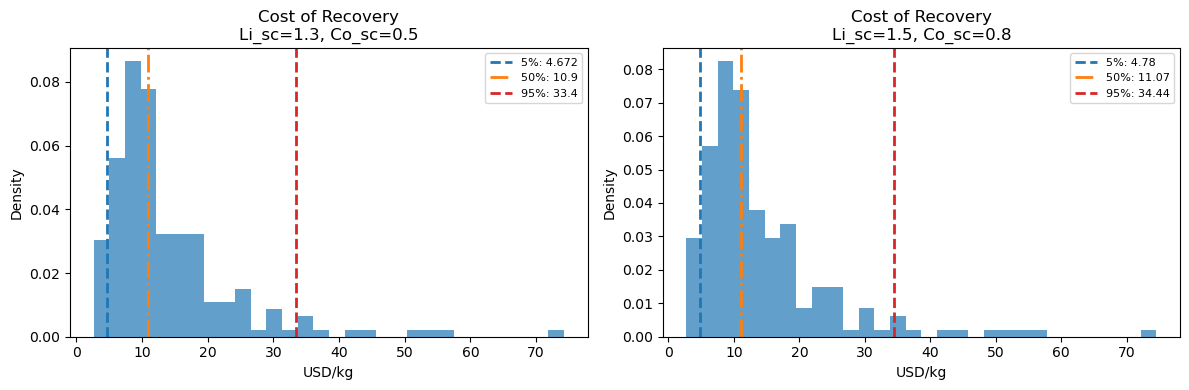

In [14]:
# (B) Cost_of_recovery comparison

fig, axes = uq.plt.subplots(1, ntech, figsize=(6 * ntech, 4), squeeze=False)
axes = axes[0]

for k, tech in enumerate(techs, start=0):
    d = results_by_technology[tech]
    rec = uq.np.asarray(d["recovery_cost_samples"], dtype=float)
    valid = rec[~uq.np.isnan(rec)]

    axes[k].hist(valid, bins=30, density=True, alpha=0.7)
    axes[k].set_title(f"Cost of Recovery\n{tech}")
    axes[k].set_xlabel("USD/kg")
    axes[k].set_ylabel("Density")

    # Mark key quantiles (valid only)
    if valid.size > 0:
        q5, q50, q95 = uq.np.percentile(valid, [5, 50, 95])
        axes[k].axvline(q5, linestyle="--", linewidth=2, color="tab:blue")
        axes[k].axvline(q50, linestyle="-.", linewidth=2, color="tab:orange")
        axes[k].axvline(q95, linestyle="--", linewidth=2, color="tab:red")
        axes[k].legend(
            [f"5%: {q5:.4g}", f"50%: {q50:.4g}", f"95%: {q95:.4g}"],
            fontsize=8,
        )

uq.plt.tight_layout()
uq.plt.show()

Although the optimized membrane lengths differ between the two technologies, the impact on the cost of recovery is relatively small, with only a slight increase observed for the (1.5, 0.8) case.

Despite substantial differences in the optimized membrane lengths, the distributions of the cost of recovery remain highly similar across the two scenarios. This behavior is consistent with the sensitivity analysis, which indicates that membrane-related parameters—such as membrane cost and replacement factors—have relatively low influence on the overall cost of recovery. Consequently, even large variations in membrane length result in only modest changes in total recovery cost.